In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ipynb.fs.defs.functions import prep_data, train, test

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Load images and labels
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [4]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [5]:
# Create train, test, and validation sets
train_dataset, test_dataset, val_dataset = prep_data(data)

In [6]:
print(
    f"Training input shape: {train_dataset.tensors[0].shape}\nTraining output shape: {train_dataset.tensors[1].shape}"
)

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 37])


## Model Definition

In [7]:
# Define a torch model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=37)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

## Training

In [8]:
# Instantiate the model
model = Model().to(DEVICE)

In [9]:
# Run a single image through the model
model_output = model(train_dataset.tensors[0][0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 37])


In [10]:
# Training Parameters
EPOCHS = 200
BATCH_SIZE = 64
LR = 0.001
GAMMA = 0.99

In [11]:
# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [12]:
# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

11/18 11:17:41 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 17.698826	Test Loss: 17.808401
11/18 11:17:45 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 17.690833	Test Loss: 17.808401
11/18 11:17:49 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 17.690974	Test Loss: 17.808401
11/18 11:17:53 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 17.690392	Test Loss: 17.808401
11/18 11:17:57 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 17.691225	Test Loss: 17.808401
11/18 11:18:01 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 17.691396	Test Loss: 17.808401
11/18 11:18:05 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 17.689605	Test Loss: 17.806219
11/18 11:18:09 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 17.688128	Test Loss: 17.804567
11/18 11:18:13 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 17.686143	Test Loss: 17.805278
11/18 11:18:17 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 17.685498	Test Loss: 17.803408
11/18 11:18:21 Train Epoch:   

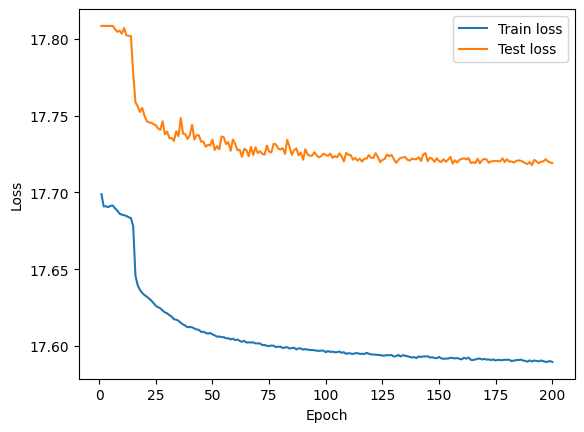

In [14]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
# Test against validation set
# Create a data loader for the training data
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_loss = test(model, val_loader, criterion)
print(f"Training loss:\t\t{train_loss[-1]}")
print(f"Testing loss:\t\t{test_loss[-1]}")
# print(f"Validation loss:\t{val_loss}")

Training loss:		17.589607050511745
Testing loss:		17.7190531307889


In [16]:
# New model
model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

# Old model
# model_name = "241114201016_model_E000_B000_LR0.00_GAMMA0.00_TRAIN_0.0000_TEST0.0000"

In [17]:
# Save the model
torch.save(model.state_dict(), "models/cross_entropy/" + model_name)
print(f"Model saved as {model_name}")

Model saved as 241118113139_model_E200_B64_LR0.001_GAMMA0.99_TRAIN17.5896_TEST17.7191.pth


In [18]:
# Load the model
model = Model()
model.load_state_dict(torch.load("models/cross_entropy/" + model_name))
model.to(DEVICE)

C:\Users\ethan\AppData\Local\Temp\ipykernel_1330976\602961557.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/cross_entropy/" + 

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)